In [1]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot") # 這行程式碼設置了 matplotlib 的繪圖風格。

# 這是 Jupyter Notebook 的魔法命令，它用於指定 matplotlib 繪圖的輸出方式。
# 可以直接在 Notebook 中看到圖形，而不需要使用 plt.show()。
%matplotlib inline 
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras import backend as K

from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras.preprocessing.image import *
from keras.callbacks import *

from keras.utils import plot_model

import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Dataset

In [2]:
class DataGen(keras.utils.Sequence):
    def __init__(self, path, ids, batch_size=8, image_size=640):
        self.path = path
        self.ids = ids
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    # 回傳 steps_per_epoch , 也就是一個 epoch 需要幾個 batch 
    def __len__(self): 
        return int(np.ceil(len(self.ids) / self.batch_size))
        
    def __load__(self, id_name):
        image_path = os.path.join(self.path, "Images", id_name)
        mask_path = os.path.join(self.path, "Mask", id_name)

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask, axis=-1)

        # Normalizaing 
        image = image / 255.0
        mask = mask / 255.0

        return image, mask

    # 獲取當次 batch 要訓練的照片
    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.ids):
            ids_batch = self.ids[index * self.batch_size : len(self.ids)]
        else:
            ids_batch = self.ids[index * self.batch_size : (index+1) * self.batch_size]
        
        images = []
        masks = []
        
        for id_name in ids_batch:
            _img, _mask = self.__load__(id_name)
            images.append(_img)
            masks.append(_mask)
        
        images = np.array(images)
        masks = np.array(masks)

        return images, masks
    
    def on_epoch_end(self):
        pass

3 ['2_jpg.rf.60369561fc1520a37e9145f6ecd47916.jpg', '4_jpg.rf.38e454f25bf0b15ff1cf507920b872bd.jpg', '8_jpg.rf.b0df4a218edbe5fb7e0e023f2428d25f.jpg']
1 ['11_jpg.rf.2e71343ba8845ca7db0b208ae1a6b064.jpg']
(1, 640, 640, 1) (1, 640, 640, 1)
(1, 640, 640, 1) (1, 640, 640, 1)


15

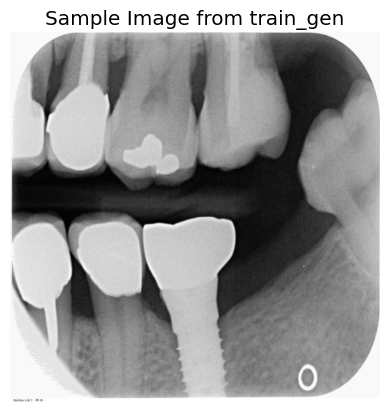

In [3]:
# 參數設定
train_path = "dataset_copy_3_imgs/train/"
train_ids = os.listdir(train_path + "Images") # list
valid_path = "dataset_copy_3_imgs/valid/"
valid_ids = os.listdir(valid_path + "Images") # list
batch_size = 1
image_size = 640

# 建立 DataGen 物件
train_gen = DataGen(train_path, train_ids, batch_size, image_size)
valid_gen = DataGen(valid_path, valid_ids, batch_size, image_size)

# 使用 DataGen 類別的 __len__ 函式
print(train_gen.__len__(), train_ids)
print(valid_gen.__len__(), valid_ids)

# 使用 DataGen 類別的 __getitem__ 函式
x, y = train_gen.__getitem__(0)
print(x.shape, y.shape)
x, y = train_gen.__getitem__(1)
print(x.shape, y.shape)

# 從 batch 中選擇其中一張圖片
image_to_display = x[0]

# 將圖片轉換為 0 到 255 的範圍
image_to_display = (image_to_display * 255).astype(np.uint8)

# 顯示圖片
plt.imshow(image_to_display[:, :, 0], cmap='gray')  # 若是彩色圖片，請將 [:, :, 0] 移除
plt.title('Sample Image from train_gen')
plt.axis('off')

gc.collect() #  用於清理不再使用的對象，釋放內存。（Garbage Collection）

## Build model

In [4]:
dropout_rate = 0.5

def conv_batchnorm_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)

    return x


def UnetPP(input_shape, n_labels, using_deep_supervision=False):

    nb_filter = [32,64,128,256,512]

    # Set image data format to channels first
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=input_shape, name='input_image')

    conv1_1 = conv_batchnorm_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_batchnorm_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_batchnorm_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv_batchnorm_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_batchnorm_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_batchnorm_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv_batchnorm_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_batchnorm_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_batchnorm_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_batchnorm_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv_batchnorm_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_batchnorm_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_batchnorm_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_batchnorm_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_batchnorm_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_1',padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_2', padding='same' )(conv1_3)
    nestnet_output_3 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_4', padding='same')(conv1_5)

    if using_deep_supervision:
        model = Model(input=inputs, output=[nestnet_output_1,
                                            nestnet_output_2,
                                            nestnet_output_3,
                                            nestnet_output_4])
    else:
        model = Model(inputs=inputs, outputs=nestnet_output_4)

    return model

In [5]:
from keras import backend as K
K.clear_session()

# input_img = Input((h, w, 1), name='img')
# del model
model = UnetPP(input_shape = (640, 640, 1), n_labels=1) # change 
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()

3281

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 640, 640, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 640, 640, 32)         320       ['input_image[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 640, 640, 32)         2560      ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 640, 640, 32)         0         ['batch_normalization[0][0

In [ ]:
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [7]:

callbacks = [
    EarlyStopping(patience=15, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=7, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model/model-UnetPP.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("result/dataUnetPP.csv"),
    TensorBoard(log_dir='./logs')
]
# >> tensorboard --logdir=path/to/logs

* `model.fit` v.s `model.fit_generator` : https://cloud.tencent.com/developer/article/1724608

In [8]:
import math

# 載入最近的檢查點的權重
if os.path.exists('model/model-UnetPP.h5'):
    model.load_weights('model/model-UnetPP.h5') # change 

train_steps = math.ceil(len(train_ids)/batch_size)
valid_steps = math.ceil(len(valid_ids)/batch_size)
print(train_steps, valid_steps)


3 1


In [9]:
results = model.fit_generator(train_gen, 
                              validation_data = valid_gen, 
                              steps_per_epoch = train_steps, 
                              validation_steps = valid_steps,
                              epochs = 3,
                              use_multiprocessing = True)

Epoch 1/3


TypeError: in user code:

    File "c:\Users\user\Desktop\Teeth-UnetPP\.venv\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\user\Desktop\Teeth-UnetPP\.venv\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\Desktop\Teeth-UnetPP\.venv\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\user\Desktop\Teeth-UnetPP\.venv\lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\user\Desktop\Teeth-UnetPP\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer 'batch_normalization' (type BatchNormalization).
    
    Failed to convert elements of [1, 1, None, 1] to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.
    
    Call arguments received by layer 'batch_normalization' (type BatchNormalization):
      • inputs=tf.Tensor(shape=(None, None, None, 32), dtype=float32)
      • training=True
      • mask=None


In [ ]:
## load weight
model.load_weights("model/model-UNetPP.h5")

## Dataset for prediction
test_path = "dataset_copy/test/"
test_ids = os.listdir(test_path + "/Images")
test_gen = DataGen(test_path, test_ids, image_size=image_size, batch_size=batch_size)
x, y = test_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [ ]:
preds_test = model.predict(test_gen, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)